#### definitions, imports, data reallocation

In [ ]:
%cd /content

/content


In [ ]:
import scipy
import os
import json
import shutil
import torch
import matplotlib.pyplot as plt
from PIL import Image

from diffusers import StableDiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
!pip install torcheval
from torcheval.metrics import FrechetInceptionDistance
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Normalize
import torch
import os


def FID(path_to_real_images:str,
        path_to_fake_images:str,
        device
):

  fid_metric = FrechetInceptionDistance(device = device)

  transform = Resize((299, 299))
  normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  def preprocess_image(image_path):
      image = Image.open(image_path).convert("RGB")
      tensor = ToTensor()(image)
      tensor = transform(tensor)
      tensor = normalize(tensor)
      tensor = torch.clamp(tensor, 0, 1)
      return tensor

  fake_images = torch.stack([preprocess_image(os.path.join(path_to_fake_images, filename)) for filename in os.listdir(path_to_fake_images)])
  real_images = torch.stack([preprocess_image(os.path.join(path_to_real_images, filename)) for filename in os.listdir(path_to_real_images)])

  fid_metric.update(real_images, is_real=True)
  fid_metric.update(fake_images, is_real=False)

  return fid_metric.compute()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.5 MB/s eta 0:00:00


In [ ]:
def generate_from_prompt(
        pipeline,
        prompt: str,
        device: str,
        output_dir: str,
        id: int,
        num_images: int = 1
):
    pipeline.to(device)

    with torch.no_grad():
        images = pipeline(prompt, num_images_per_prompt = num_images).images

    for i, image in enumerate(images):
      # Save the generated image
      name = f"{prompt.lower().replace(' ', '_')}_{id}.png"
      output_path = os.path.join(output_dir, name)

      image.save(output_path)
      print(f"Image saved at {output_path}")

In [ ]:
def data_reallocation(
    data_path: str,
    images_path: str ,
    output_path:str
):

    labels = scipy.io.loadmat(os.path.join(data_path, 'imagelabels.mat'))['labels'][0]
    with open(data_path + '/cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
    labels = [cat_to_name[str(label)] for label in labels]

    setid = scipy.io.loadmat(os.path.join(data_path, 'setid.mat'))

    train_ids = setid['trnid'][0]
    val_ids = setid['valid'][0]
    test_ids = setid['tstid'][0]

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(output_path, split)
        os.makedirs(split_path, exist_ok=True)
        for label in labels:
            os.makedirs(os.path.join(split_path, str(label)), exist_ok=True)

    def move_images(ids, split):
        for img_id in ids:
            label = labels[img_id - 1]
            src = os.path.join(images_path, f'image_{img_id:05d}.jpg')
            dst = os.path.join(output_path, split, str(label), f'image_{img_id:05d}.jpg')
            shutil.copy(src, dst)

    move_images(train_ids, 'train')
    move_images(val_ids, 'val')
    move_images(test_ids, 'test')

    print(f"Images reallocated successfully to folder {output_path}")

In [ ]:
%cd /content

/content


In [ ]:
import gdown
url = "https://drive.google.com/drive/folders/1c2xufL1sNJHbQ3v3b5l1jmYx86ahDgLQ"

gdown.download_folder(url, output='flower102')

Retrieving folder contents


Processing file 1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID 102flowers.tgz
Processing file 1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL cat_to_name.json
Processing file 1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn imagelabels.mat
Processing file 1m8mSQlD27WR2vHp-PkiQ_17ts408xn10 setid.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID
From (redirected): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID&confirm=t&uuid=8c550355-2dd4-43df-ae25-3790a0e6940d
To: /content/flower102/102flowers.tgz
100%|██████████| 345M/345M [00:03<00:00, 92.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL
To: /content/flower102/cat_to_name.json
100%|██████████| 2.22k/2.22k [00:00<00:00, 7.40MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn
From (redirected): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn&confirm=t&uuid=646ed1d9-7da4-4f4c-8bb4-0ba742b104f5
To: /content/flower102/imagelabels.mat
100%|██████████| 502/502 [00:00<00:00, 1.63MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1m8mSQlD27

['flower102/102flowers.tgz',
 'flower102/cat_to_name.json',
 'flower102/imagelabels.mat',
 'flower102/setid.mat']

In [ ]:
import tarfile
source_path = "flower102/102flowers.tgz"
destination_path = "flower102"

with tarfile.open(source_path, "r:gz") as tar:
      tar.extractall(path=destination_path)

os.remove(source_path)

In [ ]:
# Define paths
data_path = 'flower102'
images_path = os.path.join(data_path, 'jpg')
output_path = 'data'

data_reallocation(data_path,
                  images_path,
                  output_path)

Images reallocated successfully to folder data


### Generation

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

FID raw - real: 206.5880
FID trained - real: 146.5834


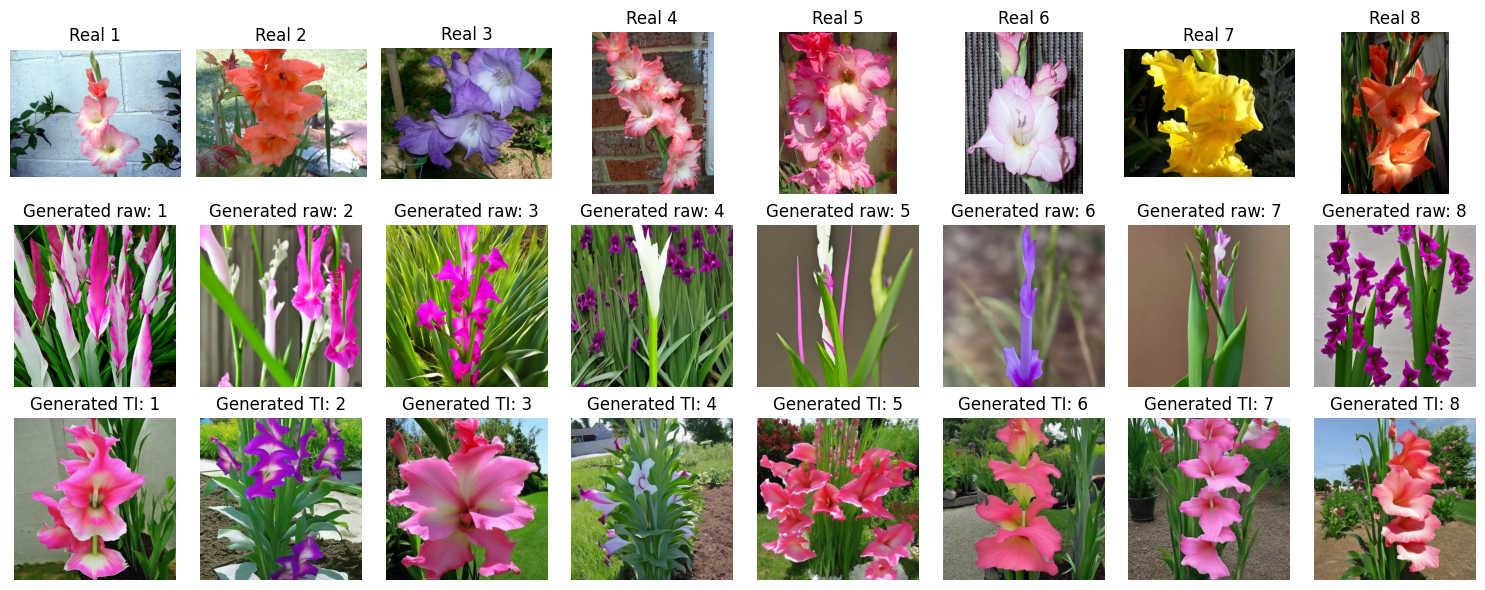

In [ ]:
model_id = "stabilityai/stable-diffusion-2" # Replace with the desired model ID
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to(device)

types = ["val", "test"]
#@markdown Enter the name of the class in Oxford 102 flower dataset
real_class_name = "sword lily" # @param ["sword lily","canna lily","azalea"]
destination_folder = "real_data"
os.makedirs(destination_folder, exist_ok=True)

for i in types:
  source_folder = f"data/{i}/sword lily"
  for filename in os.listdir(source_folder):
      source_path = os.path.join(source_folder, filename)
      destination_path = os.path.join(destination_folder, filename)
      shutil.copy2(source_path, destination_path)

#@markdown Enter the `repo_id` for a concept you like (you can find pre-learned concepts in the public [SD Concepts Library](https://huggingface.co/sd-concepts-library))
repo_id_embeds = "sd-concepts-library/sword-lily-flowers102" # @param ["sd-concepts-library/sword-lily-flowers102","sd-concepts-library/canna-lily-flowers102","sd-concepts-library/azalea-flowers102"]
pipe.load_textual_inversion(repo_id_embeds)

#@markdown Enter the name of the concept
placeholder_token = "\u003Csword lily>" # @param ["<sword lily>","<canna lily>","<azalea>"]
#@markdown Enter the name of the corresponding flower
flower_name = "gladiolus" # @param ["gladiolus","canna lily","azalea"]
concepts_to_compare = [placeholder_token, flower_name]
#@markdown Enter the number of images you want to generate
num_images = 50 #@param {"type":"integer"}

print("Start generation")

for concept in concepts_to_compare:
  output_dir = concept
  os.makedirs(output_dir, exist_ok=True)
  for i in range(num_images):
    torch.cuda.empty_cache()
    generate_from_prompt(pipeline = pipe,
                        prompt = f"A photo of a {concept}",
                        device = device,
                        output_dir = output_dir,
                        id = i,
                        num_images = 1)


print("Generation done")

FID_trained = FID(destination_folder, placeholder_token, device)
FID_raw = FID(destination_folder, flower_name, device)
print(f"FID raw - real: {FID_raw:.4f}")
print(f"FID trained - real: {FID_trained:.4f}")

torch.cuda.empty_cache()
#plot 5 images from each class
num_images_to_display = 8 # @param {"type":"integer"}
num_images_to_display = min(num_images_to_display, num_images)
fig, axes = plt.subplots(3, num_images_to_display, figsize=(15, 6))

# Display real images
for i, filename in enumerate(os.listdir(destination_folder)[:num_images_to_display]):
    image_path = os.path.join(destination_folder, filename)
    img = Image.open(image_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Real {i+1}")
    axes[0, i].axis('off')

# Display generated images
for i, filename in enumerate(os.listdir(flower_name)[:num_images_to_display]):
    image_path = os.path.join(flower_name, filename)
    img = Image.open(image_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Generated raw: {i+1}")
    axes[1, i].axis('off')

# Display generated images
for i, filename in enumerate(os.listdir(placeholder_token)[:num_images_to_display]):
    image_path = os.path.join(placeholder_token, filename)
    img = Image.open(image_path)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f"Generated TI: {i+1}")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()
